# Exercise 1: Parameter Counting and Memory Management (30 points)

Show your work for the following short-answer questions.

## part 1(a) Parameter counting (10 points)

A more advanced version of the CNN we trained may have three convolutional layers, each with $3 \times 3$ kernels, a stride of 2, and "same" padding.
The lowest (first) `Conv2D` layer outputs 100 feature maps, the middle layer outputs 200, and the top (last) one outputs 400 maps.
These operate on input images that are RGB images of $200 \times 300$ pixels.

Show that this network will comprise more than 800,000 parameters.

## part 1(b) Memory management (10 points)

The parameters in part 1(a) are typically represented using 32-bit floating point numbers.
Show that this network will require at least 12 MB of RAM when making a *prediction* for a single data instance (input image).

## part 1(c) Memory management in training(5 points)

How much RAM is needed if mini-batch *training* is used with batches of 50 images? (*Hint*: it is at least 500 MB.)

## part 1(d) RNN dimensions (5 points)

The input to an RNN layer must have three dimensions.
What does each input dimension represent?
And what do the outputs of the RNN layer represent?

### **Solution**
# 1a
This network contains three convolutional layers of $3\times{3}$ kernels. The first has 3 input nodes and 100 output nodes, so it contains $9\cdot{3}\cdot{100}+100$ parameters. The second layer has $100$ input nodes and $200$ output nodes, so it contains $9\cdot{100}\cdot{200}+200$ parameters. The third layer has $200$ input nodes and $400$ output nodes, it contains $9\cdot{200}\cdot{400}+400$ parameters. Summing, we find that the total number of parameters is given by
$$9\cdot(300+100\cdot{200}+200\cdot{400})+700=903400.$$
Since $902,700$ parameters are contained in this network, this network comprises more than $800,000$ parameters.

# 1b
Since each parameter from part a is a 32-bit float, it requires 4 bytes to store, with a total of
$$4\cdot{903400}=3613600$$
bytes. The input image has $200\cdot{300}\cdot{3}$ pixels, which takes up
$$200\cdot{300}\cdot{3}=720000$$
bytes. With a stride of 2 and same padding, we can calculate the storage necessary for each layer. The image has its size halved because of the 2 stride and same padding, hence in layer one we have
$$100\cdot{150}\cdot{4}\text{ bytes} = 6,000,000\text{ bytes}.$$
In layer two, we have
$$(\frac{100}{2})(\frac{150}{2})\cdot{4}\text{ bytes} = 3,000,000\text{ bytes}.$$
Layer three is a bit more complicated, as half of $75$ is a non-integer, $37.5$. We assume that the size is rounded up to $38$, giving us
$$25\cdot{38}\cdot{4}\text{ bytes}=1,520,000\text{ bytes}.$$
Summing, we find that using this network for predicting a single data instance will require
$$10^6(3.61+0.72+6+3+1.52)=14.85\cdot{10^6}\text{ bytes}.$$
Since 1 MB is $10^6$ bytes, we find that making a prediction for a single data instance requires more than $12$ megabytes. Specifically, it requires roughly $14.85$ megabytes of RAM.

# 1c
If we train using a batch of $50$ images, we multiply the input image sizes and the activations of layers $1,2,3$ by $50$. The parameters and gradients each contribute the same amount, as they are shared by the whole batch. Then, the total storage necessary is (in megabytes)
$$50\cdot(0.72+6+3+1.52)+3.61(2)=569.2.$$
That is, mini-batch training fifty images will require 569.2 MB of RAM.

# 1d
The input dimensions of an RNN represent the size of the batch, the number of time steps in the RNN's sequence, and the number of features at each time step respectively. The output of an RNN layer, at each time step, represents what the hidden state is at that time step. Specifically, they encode information about the RNN at that time step and all previous time steps.

# Exercise 2: CNN Training for Quantum State Classification (35 points)

In this exercise you will train a CNN on a dataset of quantum states for a particle in a 1-d box of length $L$.

The goal is to identify the quantum index of the eigenfunction: $n=1,2,3,\ldots$, or the dominant eigenfunction for a mixed state.

*Bonus question: why is the CNN a better choice for this challenge than a RNN?*



## Generate dataset

We give you the dataset generator so that everyone has a similar dataset.

The basic spatial eigenfunction is
$\psi(x) = \sqrt{\frac{2}{L}} \sin(n\pi x/L),$
but that is too simple to learn, so we add some Gaussian noise to the function to make it challenging.

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

np.random.seed(42)
torch.manual_seed(42)

# Parameters for the simulation
NUM_POINTS = 256          # points in the spatial function
NUM_CLASSES = 5           # quantum numbers n = 1 through 5
NOISE_STD = 0.3               # std of Gaussian noise to add

def generate_noisy_pinb(n_samples, noise_std=NOISE_STD, L=1.0):
    """Generate noisy wavefunctions for Particle In Box
       with known box length L."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        n = np.random.randint(1, NUM_CLASSES + 1)          # n = 1…5
        psi = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1                                       # class index 0…4
    return X, y

def make_data_loaders(generate_fn, n_train=5000, n_val=1000, batch_size=64):
    """Generate data with some `generate_fn` and wrap in DataLoaders."""
    X_train, y_train = generate_fn(n_train)
    X_val,   y_val   = generate_fn(n_val)

    # Reshape to (N, 1, NUM_POINTS) for Conv1d
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
    y_val   = torch.tensor(y_val,   dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    return (DataLoader(train_ds, batch_size, shuffle=True),
            DataLoader(val_ds,   batch_size))

train_loader, val_loader = make_data_loaders(generate_noisy_pinb)


Using device: cuda


## part 2(a): Check the dataset (5 points)

Plot the first 5 inputs in the `train_loader` as spatial functions, just to check that they look reasonable.

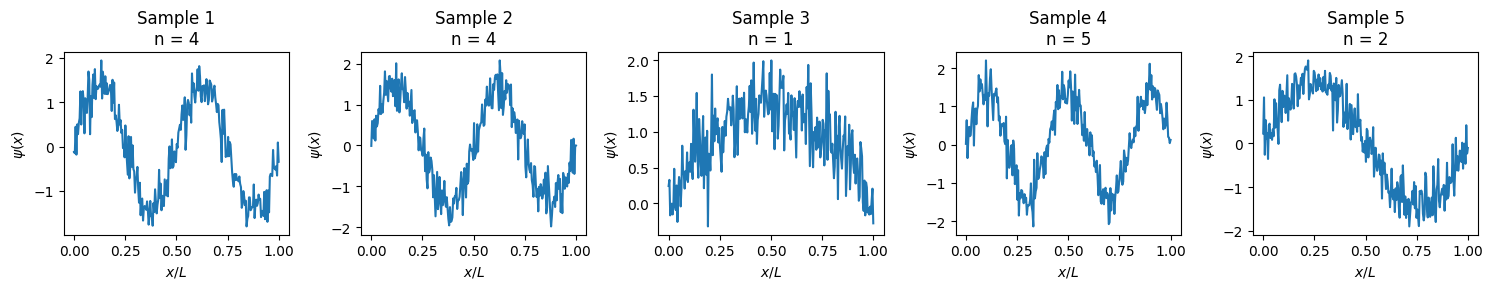

In [7]:
import matplotlib.pyplot as plt

# Look at batch 0 to extract the first few samples
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i == 0:
      fig, axes = plt.subplots(1, 5, figsize=(15, 3))
      for j in range(5):
        data = X_batch[j].squeeze().numpy()
        label = y_batch[j].item()
        x = np.linspace(0,1,NUM_POINTS)
        axes[j].plot(x, data, linewidth=1.5)
        axes[j].set_title(f'Sample {j+1}\nn = {label + 1}')
        axes[j].set_xlabel(r'$x/L$')
        axes[j].set_ylabel(r'$\psi(x)$')
        # Add your code to plot the first 5 inputs in X_batch and y_batch

plt.tight_layout() # This made the plots render more clearly for me.
plt.show()


## part 2(b): Construct CNN (10 points)

The CNN is based on the `Conv1d` object in PyTorch.

We have set up the first layer and the third layer.
- Now you add the second convolutional layer with a $5\times 5$ kernel and padding = 2.
- Explain why the last convolutional layer uses the *average* pooling method instead of the *maximum* pooling method.
- Explain what is happening with the `squeeze` in the `forward` function.



In [9]:
from torch.nn.modules.pooling import MaxPool1d
import torch.nn as nn

class WavefunctionCNN(nn.Module):
    """1-D CNN particle-in-a-box wavefunctions."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Add missing hidden layer here
            nn.Conv1d(16,32,kernel_size = 5,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, NUM_POINTS)
        x = self.features(x)
        x = x.squeeze(-1)                     # (batch, 64)
        return self.classifier(x)


The last convolutional layer uses the average pooling method instead of the maximum pooling method to analyze the features everywhere spatially. This allows us to analyze the learning features more broadly, instead of having a potential outlier mess up our classification.

The squeeze of x in the forward function allows us to remove the dimension which encodes the number of points, NUM_POINTS. This allows us to  pass x through nn.Linear, as nn.Linear requires a tensor of dimension 2 and not 3.

## part 2(c): Train CNN (5 points)

- Pick a reasonable criterion and optimizer for the CNN training and add them to the `train_model` function.
- What is the role of the `logits.argmax(1)` call inside the mini-batch training?
- Then train the CNN on the data loaders and plot the evolution of the loss and accuracy as a function of epoch.



In [11]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    # Add your criterion and optimizer here
    # We pick Cross Entropy Loss because we are doing multi-class classification.
    # Similarly, we pick the NAdam optimizer because its adaptive learning rate is useful.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            # What does logits.argmax(1) do here?
            correct += (logits.argmax(1) == y_batch).sum().item()
            total += X_batch.size(0)

        history["train_loss"].append(running_loss / total)
        history["train_acc"].append(correct / total)

        # validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += X_batch.size(0)

        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_correct / val_total)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  "
                  f"train_loss={history['train_loss'][-1]:.4f}  "
                  f"val_acc={history['val_acc'][-1]:.3f}")

    return history

Inside the mini-batch training, we use ```logits.argmax(1) ``` to find the predicted classification for accuracy checks. The ``argmax(1)``
takes the point in logits whose dimension 1 has the maximum value,
which yields the predicted classification label. We use this to determine
how close the prediction is to the true label.




Epoch   1/10  train_loss=1.1316  val_acc=0.612
Epoch   5/10  train_loss=0.1874  val_acc=0.891
Epoch  10/10  train_loss=0.0088  val_acc=1.000


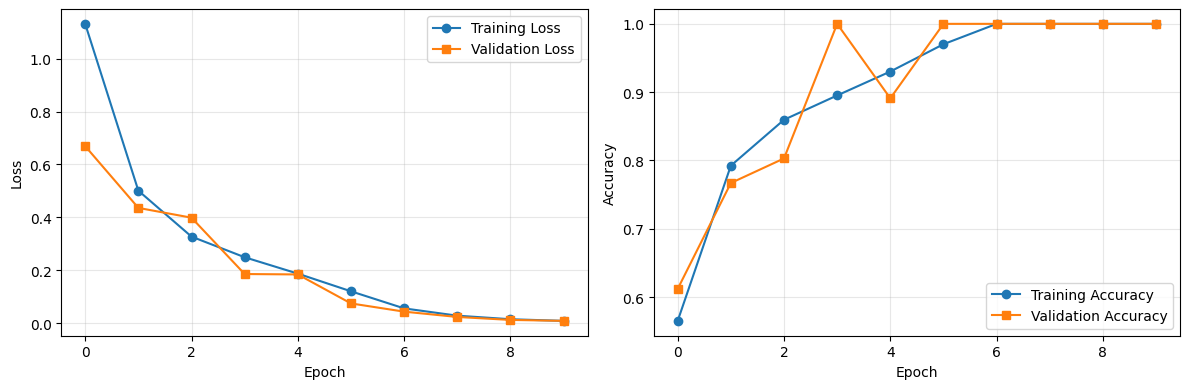


Note that our final training accuracy is 1.0000
Also, our final validation accuracy is 1.0000


In [18]:
# Write your code here to train the network using the function definitions above.
# Use the train_loader and val_loader data.
# You can use the history output to make the plots of loss and accuracy


train_loader1, val_loader1 = make_data_loaders(generate_noisy_pinb)
# We first train our model.
model = WavefunctionCNN().to(DEVICE)
history = train_model(model,train_loader1, val_loader1, epochs = 10,lr = 0.001)

# Then, we plot our results. We first plot loss, and then we plot accuracy.
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.plot(history['train_loss'], label = 'Training Loss',marker = 'o')
ax1.plot(history['val_loss'], label = 'Validation Loss',marker = 's')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True,alpha=0.3)
ax2.plot(history['train_acc'], label = 'Training Accuracy',marker = 'o')
ax2.plot(history['val_acc'], label = 'Validation Accuracy',marker = 's')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\nNote that our final training accuracy is {history['train_acc'][-1]:.4f}")
print(f"Also, our final validation accuracy is {history['val_acc'][-1]:.4f}")


Our loss and accuracy looked pretty good on the first attempt. I initially used 20 epochs, but cut it down to ten as it seemed to provide no significant increases to accuracy.

## part 2(d) (5 points)

The next challenge for the CNN is to identify the different eigenstates even with varied box lengths.

To that end, we generate a new dataset with L values varying from 0.5 to 2.0, and we add the same Gaussian noise to each curve.

Add code to retrain the CNN using these new data and evaluate the performance. How do the results compare to the results from part 2(c)?

In [15]:
def generate_varying_L(n_samples, L_range=(0.5, 2.0), noise_std=0.3):
    """Generate wavefunctions with random box length L."""
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        L = np.random.uniform(*L_range)
        n = np.random.randint(1, NUM_CLASSES + 1)
        # We always sample x in [0, L_max] and zero-pad outside [0, L]
        x = np.linspace(0, L_range[1], NUM_POINTS, endpoint=False)
        psi = np.where(x <= L,
                       np.sqrt(2 / L) * np.sin(n * np.pi * x / L),
                       0.0)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1
    return X, y


Epoch   1/100  train_loss=1.5990  val_acc=0.284
Epoch   5/100  train_loss=1.2763  val_acc=0.529
Epoch  10/100  train_loss=0.7045  val_acc=0.744
Epoch  15/100  train_loss=0.4926  val_acc=0.834
Epoch  20/100  train_loss=0.3898  val_acc=0.872
Epoch  25/100  train_loss=0.3226  val_acc=0.850
Epoch  30/100  train_loss=0.2732  val_acc=0.914
Epoch  35/100  train_loss=0.2338  val_acc=0.924
Epoch  40/100  train_loss=0.1998  val_acc=0.950
Epoch  45/100  train_loss=0.1689  val_acc=0.970
Epoch  50/100  train_loss=0.1418  val_acc=0.973
Epoch  55/100  train_loss=0.1179  val_acc=0.983
Epoch  60/100  train_loss=0.0975  val_acc=0.984
Epoch  65/100  train_loss=0.0803  val_acc=0.991
Epoch  70/100  train_loss=0.0667  val_acc=0.993
Epoch  75/100  train_loss=0.0550  val_acc=0.993
Epoch  80/100  train_loss=0.0461  val_acc=0.994
Epoch  85/100  train_loss=0.0389  val_acc=0.994
Epoch  90/100  train_loss=0.0330  val_acc=0.994
Epoch  95/100  train_loss=0.0287  val_acc=0.995
Epoch 100/100  train_loss=0.0250  val_ac

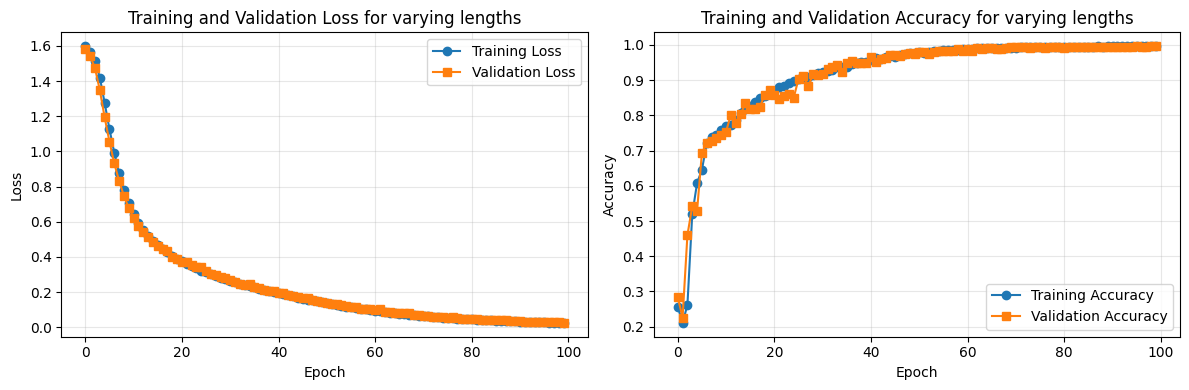

In [21]:
# Write your code here to
# - put the generate_varying_L data into data loaders
# - use those data to retrain the CNN
# - use the history output to make the plots of loss and accuracy
train_loader2, val_loader2 = make_data_loaders(generate_varying_L, n_train = 5000,n_val = 1000, batch_size = 64)
model2 = WavefunctionCNN().to(DEVICE)
# We train on data of varying box lengths.
history2 = train_model(model2,train_loader2, val_loader2,epochs=100,lr = 0.0001)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Then, we plot our loss and accuracy.
ax1.plot(history2['train_loss'], label = 'Training Loss',marker = 'o')
ax1.plot(history2['val_loss'], label = 'Validation Loss',marker = 's')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True,alpha=0.3)
ax1.set_title('Training and Validation Loss for varying lengths')
ax2.plot(history2['train_acc'], label = 'Training Accuracy',marker = 'o')
ax2.plot(history2['val_acc'], label = 'Validation Accuracy',marker = 's')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy for varying lengths')
ax2.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()



The results eventually converge to those of part c, but require more epochs to get there. Additionally, the loss function spikes and accuracy drops sharply at several points during training. The model does overcome these new challenges imposed by varying lengths, but it requires at least 15 epochs to get to the same performance as that of the model of part c. Dropping the learning rate to 0.0001 made the loss and validation decrease and increase more steadily, respectively. However, it required almost eighty epochs to reach similar performance. This was not super noticeable computationally given the scope of this dataset, but could become significant with a larger dataset/more noise.

## part 2(e) (5 points)

Now for the biggest challenge of all.

Each sample is now a normalized superposition

$$\Psi(x) = \alpha\,\psi_m(x) + \beta\,\psi_n(x), \qquad \alpha^2 + \beta^2 = 1$$

where $m \neq n$ are drawn at random and $|\alpha| > |\beta|$ by construction.
The label is the **dominant** quantum number $m$.

The CNN will have to figure out the dominant quantum number.

This is significantly harder than the previous challenges because the CNN must disentangle overlapping spatial
frequencies.

Use the function below to generate the data; then retrain the CNN to find the dominant quantum number.


In [22]:
def generate_superposition(n_samples, L=1.0, noise_std=0.05):
    """Generate superpositions of two states; label = dominant n."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Pick two distinct quantum numbers
        m, n = np.random.choice(range(1, NUM_CLASSES + 1), size=2, replace=False)

        # Random mixing angle; ensure |alpha| > |beta|
        theta = np.random.uniform(0, np.pi / 4)     # alpha = cos θ ≥ cos(π/4) ≈ 0.71
        alpha, beta = np.cos(theta), np.sin(theta)

        psi_m = np.sqrt(2 / L) * np.sin(m * np.pi * x / L)
        psi_n = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        psi   = alpha * psi_m + beta * psi_n

        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = m - 1        # dominant quantum number

    return X, y


Epoch   1/200  train_loss=1.6012  val_acc=0.368
Epoch   5/200  train_loss=1.1547  val_acc=0.585
Epoch  10/200  train_loss=1.0242  val_acc=0.622
Epoch  15/200  train_loss=0.9780  val_acc=0.768
Epoch  20/200  train_loss=0.9199  val_acc=0.778
Epoch  25/200  train_loss=0.8448  val_acc=0.836
Epoch  30/200  train_loss=0.7574  val_acc=0.866
Epoch  35/200  train_loss=0.6688  val_acc=0.879
Epoch  40/200  train_loss=0.5915  val_acc=0.881
Epoch  45/200  train_loss=0.5278  val_acc=0.890
Epoch  50/200  train_loss=0.4742  val_acc=0.895
Epoch  55/200  train_loss=0.4288  val_acc=0.888
Epoch  60/200  train_loss=0.3891  val_acc=0.902
Epoch  65/200  train_loss=0.3535  val_acc=0.897
Epoch  70/200  train_loss=0.3221  val_acc=0.904
Epoch  75/200  train_loss=0.2927  val_acc=0.909
Epoch  80/200  train_loss=0.2686  val_acc=0.916
Epoch  85/200  train_loss=0.2466  val_acc=0.925
Epoch  90/200  train_loss=0.2277  val_acc=0.931
Epoch  95/200  train_loss=0.2093  val_acc=0.939
Epoch 100/200  train_loss=0.1945  val_ac

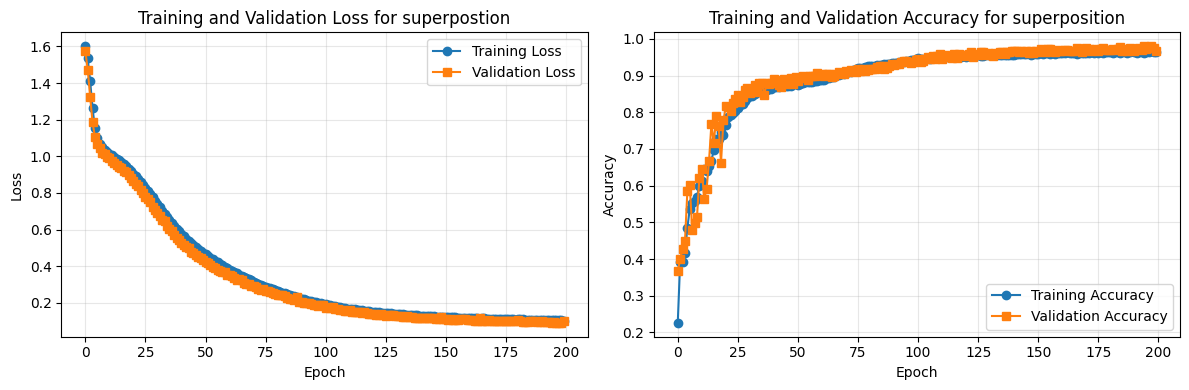


Note that our final training accuracy is 0.9636
Moreover, our final validation accuracy is 0.9670


In [26]:
# Write your code here to
# - put the generate_superposition data into data loaders
# - use those data to retrain the CNN and plot results
train_loader3, val_loader3 = make_data_loaders(generate_superposition, n_train=5000, n_val=1000, batch_size=64)
model3 = WavefunctionCNN().to(DEVICE)
history3 = train_model(model3, train_loader3,val_loader3,epochs=200,lr=0.0001)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Then, we plot our loss and accuracy.
ax1.plot(history3['train_loss'], label = 'Training Loss',marker = 'o')
ax1.plot(history3['val_loss'], label = 'Validation Loss',marker = 's')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True,alpha=0.3)
ax1.set_title('Training and Validation Loss for superpostion')
ax2.plot(history3['train_acc'], label = 'Training Accuracy',marker = 'o')
ax2.plot(history3['val_acc'], label = 'Validation Accuracy',marker = 's')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy for superposition')
ax2.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\nNote that our final training accuracy is {history3['train_acc'][-1]:.4f}")
print(f"Moreover, our final validation accuracy is {history3['val_acc'][-1]:.4f}")

A learning rate of 0.001 yielded, as in part d, stochastic jumps and dips in the loss  and accuracy respectively. Dropping it to 0.0001 yielded a more stable convergence, albeit at the cost of more epochs. At this scale, the computational difference was noticeable, although I believe it was useful as the loss function and accuracy seem much more stable. The true number of useful epochs is likely around 180.

## part 2(f) (5 points)

- Use `scikit-learn.confusion_matrix` to display the confusion matrix for the 5 labeled classes.
- Which states were most easily confused? Explain the reason for the confusion, using your knowledge of quantum mechanics.

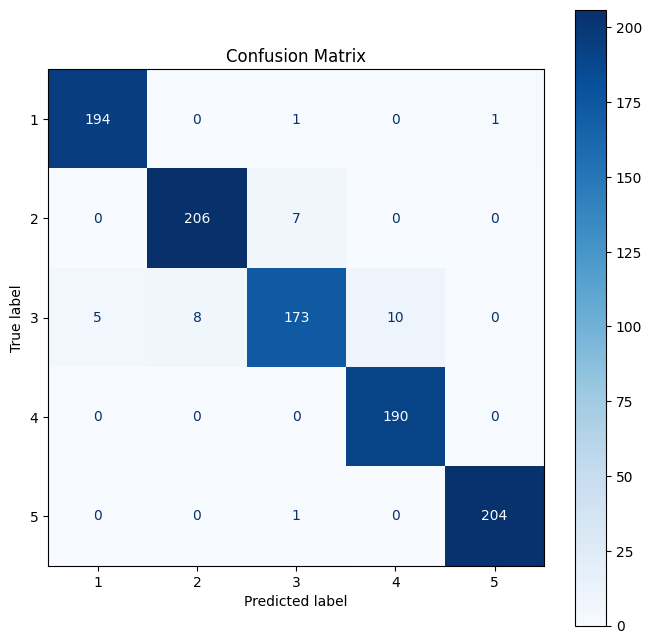

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model3.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader3:
      X_batch = X_batch.to(DEVICE)
      logits = model3(X_batch)
      preds = logits.argmax(dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(y_batch.cpu().numpy())
cm = confusion_matrix(all_labels,all_preds)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(1,6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
plt.show()

The most frequently confused states were states 2 and 3 with each other and states 3 and 4. This is likely because these states are adjacent (i.e. $m-n<2$) and hence have similar amounts of nodes and spatial structure. Specifically, adjacent states have only a single node of difference. This is exacerbated by the fact that we are considering superpositions of states, wherein the wavefunction becomes "blurry" and the nodes become slightly more difficult to classify.

# Exercise 3: LSTM Training for Orbital Mechanics (35 points)

The LSTM can learn a series of positions of an orbiting body (Keplerian orbit).

In this exercise you will generate the orbital data and then train the `OrbitLSTM` to predict the orbit given a starting point and a few steps.



In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


This is the code to generate the dataset.

At each step the state is a 4-dimensional vector:

$$\mathbf{s}(t) = (x,\; y,\; v_x,\; v_y)$$

The gravitational equations of motion (with $\mu = GM = 1$) are:

$$\ddot{x} = -\frac{x}{r^3}, \qquad \ddot{y} = -\frac{y}{r^3}, \qquad r = \sqrt{x^2 + y^2}$$

We derive initial conditions at perihelion (closest approach):

$$x_0 = a(1-e), \quad y_0 = 0, \quad v_{x,0} = 0, \quad v_{y,0} = \sqrt{\frac{\mu(1+e)}{a(1-e)}},$$

where $a$ is the semi-major axis and $e$ is the eccentricity.

In [35]:
def kepler_initial_conditions(a: float, e: float, mu: float = 1.0) -> np.ndarray:
    """
    Compute initial state vector [x, y, vx, vy] at perihelion for a
    Kepler orbit with semi-major axis `a` and eccentricity `e`.
    """
    r_peri = a * (1.0 - e)
    v_peri = np.sqrt(mu * (1.0 + e) / (a * (1.0 - e)))
    return np.array([r_peri, 0.0, 0.0, v_peri])

def gravitational_acceleration(pos: np.ndarray, mu: float = 1.0) -> np.ndarray:
    """
    Compute gravitational acceleration at position `pos`.
    """
    r = np.linalg.norm(pos)
    return -mu * pos / r**3

def integrate_orbit(state0: np.ndarray, dt: float, n_steps: int,
                    mu: float = 1.0) -> np.ndarray:
    """
    Integrate a 2D Kepler orbit using the Velocity Verlet method.
    """
    trajectory = np.zeros((n_steps + 1, 4))
    trajectory[0] = state0

    pos = state0[:2].copy()
    vel = state0[2:].copy()
    acc = gravitational_acceleration(pos, mu)

    for i in range(1, n_steps + 1):
        pos = pos + vel * dt + 0.5 * acc * dt**2
        acc_new = gravitational_acceleration(pos, mu)
        vel = vel + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        trajectory[i] = np.concatenate([pos, vel])

    return trajectory

def generate_orbit_dataset(n_orbits: int = 500, steps_per_orbit: int = 300,
                            a_range: tuple = (0.8, 1.2),
                            e_range: tuple = (0.0, 0.2),
                            mu: float = 1.0) -> list:
    """
    Generate a list of orbital trajectories with random parameters.
    """
    orbits = []
    for _ in range(n_orbits):
        a = np.random.uniform(*a_range)
        e = np.random.uniform(*e_range)
        state0 = kepler_initial_conditions(a, e, mu)
        T_orbital = 2.0 * np.pi * a**1.5
        dt = T_orbital / steps_per_orbit
        traj = integrate_orbit(state0, dt, steps_per_orbit, mu)
        orbits.append(traj)
    return orbits

class OrbitDataset(Dataset):
    """
    PyTorch Dataset for next-step prediction on orbital trajectories.

    Each sample is:
        X: states[i : i + seq_len]          shape (seq_len, 4)
        Y: states[i + seq_len]              shape (4,)
    """

    def __init__(self, orbits: list, seq_len: int = 20):
        self.samples_X = []
        self.samples_Y = []
        for traj in orbits:
            for i in range(len(traj) - seq_len):
                self.samples_X.append(traj[i:i + seq_len])
                self.samples_Y.append(traj[i + seq_len])
        self.samples_X = np.array(self.samples_X, dtype=np.float32)
        self.samples_Y = np.array(self.samples_Y, dtype=np.float32)

    def __len__(self):
        return len(self.samples_X)

    def __getitem__(self, idx):
        return (torch.tensor(self.samples_X[idx]),
                torch.tensor(self.samples_Y[idx]))

In [36]:
# Generate the data
print("Generating training orbits...")
train_orbits = generate_orbit_dataset(n_orbits=400, steps_per_orbit=300)
print("Generating validation orbits...")
val_orbits = generate_orbit_dataset(n_orbits=100, steps_per_orbit=300)

SEQ_LEN = 30
train_dataset = OrbitDataset(train_orbits, seq_len=SEQ_LEN)
val_dataset = OrbitDataset(val_orbits, seq_len=SEQ_LEN)

print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

Generating training orbits...
Generating validation orbits...
Training samples:   108,400
Validation samples: 27,100


We generate many orbits with randomised parameters, then package them for PyTorch. The RNN receives a window of `seq_len` consecutive states and predicts the next state.


The class `OrbitLSTM` defines the model to be trained.
1. An stacked LSTM encoder processes the input sequence.
2. A fully-connected head (last layer) maps the final hidden state to the predicted next state.

In [37]:
class OrbitLSTM(nn.Module):
    """
    LSTM model for next-step orbital state prediction.

    Parameters
    ----------
    input_size : int
        Dimensionality of the state vector (default 4).
    hidden_size : int
        Number of LSTM hidden units.
    num_layers : int
        Number of stacked LSTM layers.
    dropout : float
        Dropout between LSTM layers (only used if num_layers > 1).
    """

    def __init__(self, input_size: int = 4, hidden_size: int = 64,
                 num_layers: int = 3, dropout: float = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : Tensor of shape (batch, seq_len, 4)

        Returns
        -------
        Tensor of shape (batch, 4) — predicted next state.
        """
        lstm_out, _ = self.lstm(x)         # (batch, seq_len, hidden)
        last_hidden = lstm_out[:, -1, :]   # (batch, hidden)
        return self.fc(last_hidden)        # (batch, 4)


## part 3(a): Set up training (5 points)

The model is already set up for you. Now
- add your code to evaluate the average loss per epoch
- add an optimizer and scheduler suitable for LSTM model

In [40]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Train for one epoch. Returns average loss."""
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    """Evaluate on a dataset. Returns average loss."""
    # Add your code to calculate the loss per batch and the total_loss
    # You can look in the train_one_epoch function for help
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          pred = model(X_batch)
          loss = loss_fn(pred, y_batch)
          total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)



def train_model(model, train_loader, val_loader, n_epochs=20, lr=1e-3,
                loss_fn=None, device=device):
    """
    Full training loop with logging.

    Returns
    -------
    dict with keys 'train_losses' and 'val_losses'.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Add your optimizer and scheduler here
    # We add the NAdam optimizer because it works well with LSTMs. We also use a step learning
# rate scheduler.
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    history = {"train_losses": [], "val_losses": []}

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        history["train_losses"].append(train_loss)
        history["val_losses"].append(val_loss)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history


## part 3(b): Train LSTM (10 points)

Train the LSTM with reasonable values of `num_layers`, `dropout`, and `hidden_size`.

You will need to evaluate the performance using the cells below.

In [63]:
# Create data loaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Instantiate and train the baseline model with reasonable parameters
# We increase hidden size to be more capable of figuring out the positions.
# input_size seems reasonable, we change num_layers to 3 but not higher,
# to account for potential complexities. We don't drop the droput too much
# (no pun intended) because a low dropout could run the risk of overfitting.
model_baseline = OrbitLSTM(input_size=4, hidden_size=64, num_layers=2, dropout=0.325).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_baseline.parameters()):,}")
print("\nTraining baseline model (MSE loss)...")
history_baseline = train_model(model_baseline, train_loader, val_loader, n_epochs=40)


Model parameters: 55,620

Training baseline model (MSE loss)...


/tmp/ipython-input-1674240206.py:56: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  scheduler.step(val_loss)


Epoch   1 | Train Loss: 0.032240 | Val Loss: 0.005054
Epoch   5 | Train Loss: 0.000298 | Val Loss: 0.000147
Epoch  10 | Train Loss: 0.000164 | Val Loss: 0.000052
Epoch  15 | Train Loss: 0.000127 | Val Loss: 0.000191
Epoch  20 | Train Loss: 0.000108 | Val Loss: 0.000058
Epoch  25 | Train Loss: 0.000103 | Val Loss: 0.000275
Epoch  30 | Train Loss: 0.000085 | Val Loss: 0.000047
Epoch  35 | Train Loss: 0.000080 | Val Loss: 0.000038
Epoch  40 | Train Loss: 0.000068 | Val Loss: 0.000053


The above code was initially run at 30 epochs. I altered to 20 as the final ten epochs seemed to give no additional benefit to the losses in either train or val.

## part 3(c): Evaluate training and validation loss (5 points)

Add your code inside `plot_training_curves` to plot the training and validation loss as a function of training epoch.

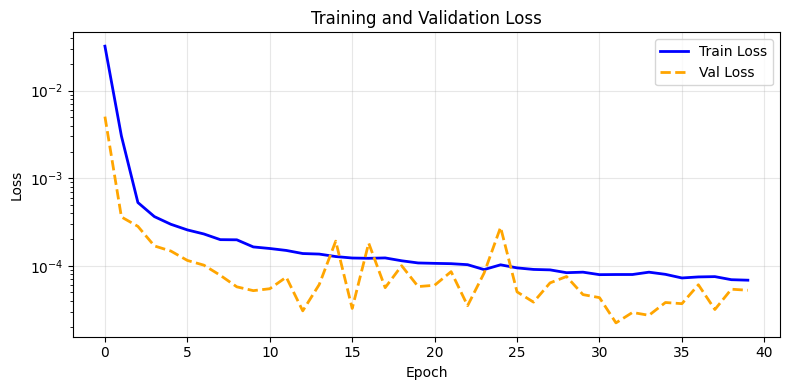

In [64]:
# Implement the function plot_training curves to plot the training loss
#  and validation loss as a function of training epoch

def plot_training_curves(history, title="Training Curves"):
    """Plot train and validation loss over epochs."""
    # Add code here
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(history['train_losses'], label='Train Loss', color='blue', lw=2)
    ax.plot(history['val_losses'], label='Val Loss', color='orange', linestyle='--', lw=2)
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True,alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_training_curves(history_baseline, "Baseline LSTM — Training Curves")

I tried out log plotting, and it seemed to shed more clarity on what the loss on training and validation looked like. Without the line on setting y scale to be log, it looked like a straight shot down.

The real test of the training is to give the model a starting sequence of points and have it map out an entire orbit. We can compare how well it matches the results from the equations of motion.

In [65]:
def rollout_trajectory(model, seed_states: np.ndarray, n_steps: int,
                       device=device) -> np.ndarray:
    """
    Autoregressively predict a trajectory.

    Parameters
    ----------
    model : OrbitLSTM
        Trained model.
    seed_states : np.ndarray of shape (seq_len, 4)
        Initial window of true states to seed the rollout.
    n_steps : int
        Number of additional steps to predict.
    device : torch.device

    Returns
    -------
    np.ndarray of shape (seq_len + n_steps, 4)
        The seed states followed by predicted states.
    """
    model.eval()
    seq_len = seed_states.shape[0]
    result = list(seed_states)

    window = torch.tensor(seed_states, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(window)                # (1, 4)
            pred_np = pred.cpu().numpy()[0]
            result.append(pred_np)
            # Slide window forward
            new_step = pred.unsqueeze(1)        # (1, 1, 4)
            window = torch.cat([window[:, 1:, :], new_step], dim=1)

    return np.array(result)


## part 3(d): Update training to optimize performance (15 points)

Test the model by plotting the prediction against the truth calculated by integrating the equations of motions.

Are you satisfied with the results? If not, go back and adjust some of the model parameters and training parameters until you are satisfied.

During this process you will need to think carefully about the LSTM:
- What is it learning?
- What are its limitations?
- What do the training vs. validation loss tell you?
- Are the test data in the plot well learned by the LSTM?

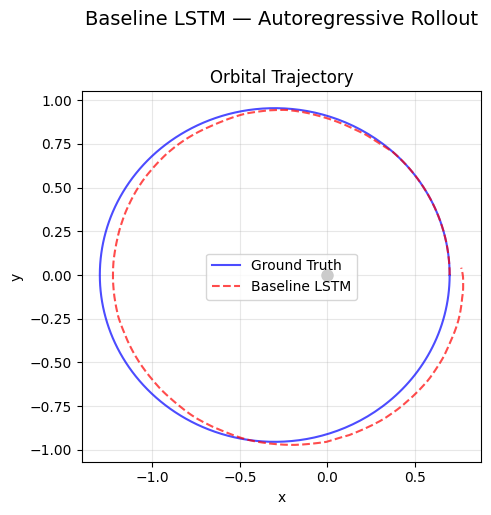

In [66]:
def evaluate_rollout(model, test_orbit: np.ndarray, seq_len: int = 20,
                     label: str = "Model"):
    """
    Roll out a prediction and plot trajectory
    compared to the ground truth.
    """
    n_predict = len(test_orbit) - seq_len
    seed = test_orbit[:seq_len]
    pred_traj = rollout_trajectory(model, seed, n_predict)
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    # Trajectory
    ax.plot(test_orbit[:, 0], test_orbit[:, 1], 'b-', alpha=0.7, label='Ground Truth')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', alpha=0.7, label=label)
    ax.plot(0, 0, 'ko', markersize=8)  # Central body
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Orbital Trajectory')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f"{label} — Autoregressive Rollout", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate a test orbit (moderate eccentricity)
a_test, e_test = 1.0, 0.3
state0_test = kepler_initial_conditions(a_test, e_test)
T_test = 2 * np.pi * a_test**1.5
test_orbit = integrate_orbit(state0_test, T_test / 300, 300)

baseline_metrics = evaluate_rollout(model_baseline, test_orbit, seq_len=SEQ_LEN,
                                     label="Baseline LSTM")


I am mostly satisfied with the results. I increased dropout and the number of epochs, and it seemed to fit the trajectory more accurately. The LSTM has inherent limitations where error propagates as each small error in the hidden state contributes to the computation of the next position step, which propagates more and more error. The validation loss is generally less than the training loss, although the validation loss tends to spike more than the training loss. This tells me that it could be overfitting slightly, but I am satisfied enough with the results to not tune to parameters further. The test data in the plot appear to be relatively well learned by the LSTM, with  some error propagation at certain points on the trajectory compounding.